# Los Angeles Crime Forecasting
#### Authors: David Bruce, Sidney Kung, Lhamu Tsering

<img src="visualizations/los-angeles-us-banner-dp-min.png">

## Overview

Enter text here

## Business Problem

Enter text here

## Data Understanding

The data has 1,993,259 observations over 26 variables. Each row is a record of information on crime that was reported, where it occurred, when it occurred, what the crime was, and information on the victims of the crime. The crime data information is daily crime data collected from January of 2010 to end of June 2019.

In [1]:
# Importing Utility Functions
import numpy as np
import pandas as pd
import pickle
import itertools

# Importing statmodels tools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
 
# Ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Importing Graphing libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
import folium

# Importing Models
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm


%load_ext autoreload
%autoreload 2
from src import modules

In [2]:
# Loading crime data csv file
df = pd.read_csv('data/extracted/crime-data-from-2010-to-present.csv')

In [3]:
# Preview of crime data
df.head()

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Weapon Description,Status Code,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,Location
0,102005556,2010-01-25T00:00:00,2010-01-22T00:00:00,2300,20,Olympic,2071,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,VAN NESS,15TH,"{'latitude': '34.0454', 'needs_recoding': Fals..."
1,101822289,2010-11-11T00:00:00,2010-11-10T00:00:00,1800,18,Southeast,1803,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,88TH,WALL,"{'latitude': '33.9572', 'needs_recoding': Fals..."
2,101105609,2010-01-28T00:00:00,2010-01-27T00:00:00,2230,11,Northeast,1125,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,YORK,AVENUE 51,"{'latitude': '34.1211', 'needs_recoding': Fals..."
3,101620051,2010-11-11T00:00:00,2010-11-07T00:00:00,1600,16,Foothill,1641,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,EL DORADO,TRUESDALE,"{'latitude': '34.241', 'needs_recoding': False..."
4,101910498,2010-04-07T00:00:00,2010-04-07T00:00:00,1600,19,Mission,1902,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,GLENOAKS,DRELL,"{'latitude': '34.3147', 'needs_recoding': Fals..."


In [4]:
df.shape

(1993259, 26)

## Data Cleaning
We will be loading the cleaned dataframe to work on further. However, **the detailed data cleaning process can be found in the data cleaning [notebook](./data_cleaning.ipynb)**

In [5]:
# Loading pickled cleaned df for ease of work in final notebook
clean_df = pd.read_pickle('data/pickled/cleaned_df.pkl')

## Data EDA

A detailed EDA can be found in the [EDA notebook](./EDA/EDA.ipynb).
Here, we will mainly explore data to show how our business questions were investigated.
We also look at the autocorrelation of the time series. To look at the linear relationship between numeric data we check the correlation factor. Similarly, in time series the linear relationship between a value and its previous observed value is checked on, by looking at the autocorrelation. 
We also explore decomposition of the time series data to examine seasonality and trends.

#### What areas in LA have the highest crime rate?

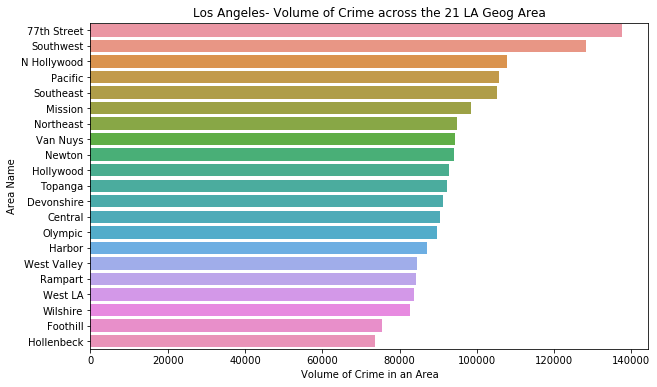

In [6]:
# Setting up figure
plt.figure(figsize=(10,6))

# Plotting categorial count plot for crime by area
sns.countplot(y='Area Name', data= clean_df, orient="h", 
              order=clean_df['Area Name'].value_counts().index)

# Setting x axis label and figure title
plt.xlabel('Volume of Crime in an Area')
plt.title('Los Angeles- Volume of Crime across the 21 LA Geog Area');

In [7]:
clean_df['Area Name'].value_counts()[:6]

77th Street    137513
Southwest      128111
N Hollywood    107707
Pacific        105655
Southeast      105104
Mission         98395
Name: Area Name, dtype: int64

The top 5 areas where most of the crimes in LA have occured among the 21 geographic areas is 77th Street, Southwest, North Hollywood, Pacific, and Southeast.

In [8]:
# creating crime_df with each unique crime and associated area name
crime_df = df[['DR Number','Area Name']]
# renaming columns
crime_df.rename(columns={"DR Number": "IncidentID", 'Area Name':'Area'}, inplace=True)

# creating crime_counts_df with the count of crime in each area
crime_counts_df = crime_df.groupby('Area').size().reset_index()
crime_counts_df = crime_counts_df.rename({0: 'num_crimes'}, axis='columns')

# fixing area names so they appear on the map
crime_counts_df['Area'] = crime_counts_df['Area'].str.replace('N Hollywood', 'North Hollywood')
crime_counts_df['Area'] = crime_counts_df['Area'].str.replace('West LA', 'West Los Angeles')


In [9]:
LAgeo = r'data/LAPD_Divisions.json'

mapLACrimes = folium.Map(
    location=[34.052235, -118.243683], 
    zoom_start=10, 
    tiles='cartodbpositron', 
)

mapLACrimes.choropleth(
    geo_data=LAgeo,
    name='choropleth',
    data=crime_counts_df,
    columns=['Area', 'num_crimes'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Reported Crimes in LA from 2010-2019'
)

In [10]:
mapLACrimes

#### What are the top 3 vulnerable demographics in LA?

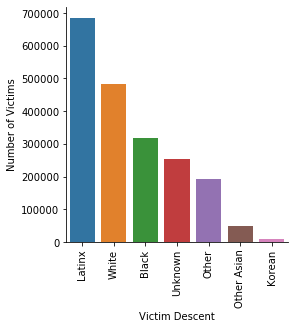

In [11]:
# Plotting  a countplot of Victim Descent
g = sns.catplot(x="Victim Descent", 
                data=clean_df, 
                kind="count",
                height=4, orient="h",
                order=clean_df['Victim Descent'].value_counts()[:7].index)

#setting x tick labels
g.set_xticklabels(['Latinx','White','Black','Unknown', 'Other', 'Other Asian','Korean'], rotation= 'vertical')

#setting y label
g.set_ylabels('Number of Victims')
g.set_titles('Distribution of victims by Descent');

In [12]:
# Proportion of victims sorted in descenting order for the 
clean_df['Victim Descent'].value_counts(normalize= True)[:10]

H    0.343869
W    0.242334
B    0.159008
X    0.127551
O    0.096124
A    0.024052
K    0.004366
F    0.001183
C    0.000443
I    0.000437
Name: Victim Descent, dtype: float64

For all the crimes reported between 2010 and June of 2019, at 34%, victims of *Latinx* descent account for the highest number of victims of crimes in that period. White victims account for 24% and Black victims account for 16% of all crime victims in that period.

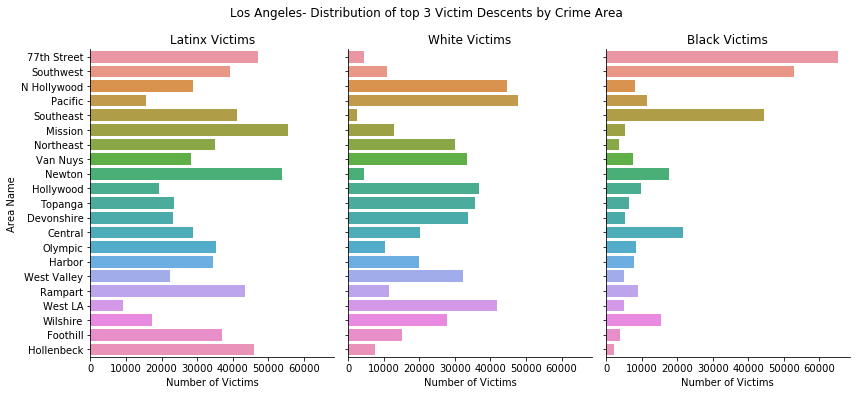

In [13]:
# Plotting a categorical estimate plot of Crime area by Descent
g = sns.catplot(y="Area Name", col="Victim Descent",
                col_order= clean_df['Victim Descent'].value_counts()[:3].index
                ,data=clean_df, kind="count",height=5, aspect=.8,
               order=clean_df['Area Name'].value_counts().index)

# Setting label an title for first facet
g.axes[0,0].set_xlabel('Number of Victims')
g.axes[0,0].set_title('Latinx Victims')

# Setting label an title for second facet
g.axes[0,1].set_xlabel('Number of Victims')
g.axes[0,1].set_title('White Victims')

# Setting label an title for third facet
g.axes[0,2].set_xlabel('Number of Victims')
g.axes[0,2].set_title('Black Victims')

#setting figure title for facetgrid plot
g.fig.suptitle('Los Angeles- Distribution of top 3 Victim Descents by Crime Area ', y = 1.05);

Looking at the top 3 vulnerable demographics in LA, Black and Latinx communities has most suffered in the highest crime occuring areas of 77th Street and Southeast. This could also be that there are lesser White people living in these two areas. White victims are highest in the North Hollywood, Pacific areas. Again, this could be because these areas have higher white population. Similarly, areas such as Mission, Newton, Rampart, Foothill and Hollenbeck have a higher number of Latinx victims than the other descents.

#### How much has crime fluctuated in the last 10 years?
To explore data on this query we must first convert the data to where the columns hold annual data and the rows hold monthly data

In [14]:
# Grouping data by date in index
crime_volume = pd.DataFrame(clean_df.groupby(clean_df.index.date).size(), 
                            columns=['crime_count']).reset_index()

# pulling out date from index to convert to datetime object
crime_volume.rename(columns = {'index':'Date'}, inplace = True)

# Converting Date column to datetime object
crime_volume['Date']= pd.to_datetime(crime_volume['Date'], format='%Y-%m-%d')

#setting datetime object as index
crime_volume.set_index('Date', inplace=True)


# Resample monthly average crime from datetime index
monthly_crime=round(crime_volume.resample('MS').mean(),2)

# uncomment code to preview data
# monthly_crime.head() 

In [15]:
# Grouping data annually
year_groups= monthly_crime.groupby(pd.Grouper(freq='A'))

# Create a new DataFrame and store yearly values in columns 
annual_crime = pd.DataFrame()

#looping throup the year_unemp groupby object as a tuple
for date,group in year_groups:
    year = date.year          #pulling the year from datetime object
    if year == 2019:          # removing year for incomplete data
        break
    series = group.values.ravel()  # flattening the array
    annual_crime[year] = series
    
# uncomment code to preview data
# annual_crime.head() 

**Now we investigate the query of crime fluctuation from year to year in data with a boxplot**

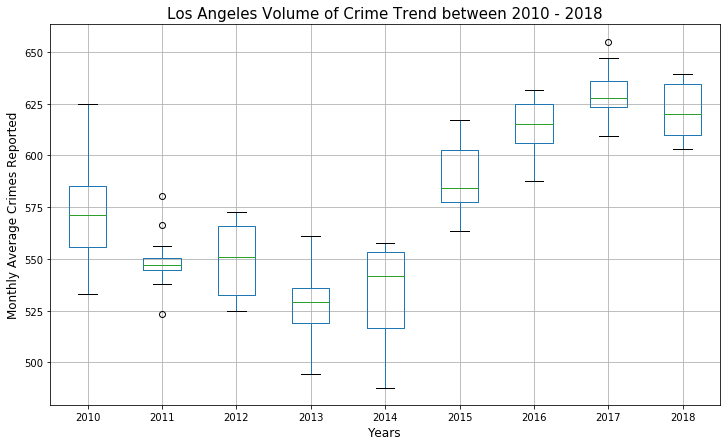

In [16]:
# Generate a box and whiskers plot for last 10 years
annual_crime.boxplot(figsize=(12,7))

#Setting figure title
plt.title('Los Angeles Volume of Crime Trend between 2010 - 2018', size = 15)

#Setting x and y label
plt.xlabel('Years', size=12)
plt.ylabel('Monthly Average Crimes Reported', size = 12)

plt.show();

The average monthly crime in the period between 2010 and 2018 ranges between 530 crimes per month to 630 crimes per months. We can also see that 2017 saw the highest average number of crimes reported, while 2013 saw the lowest average number of crimes reported in LA. 

**EDA - Autocorrelation**
We will look at the Autocorrelation function (ACF) plot or correlogram and the Partial Autocorrelation Function (PACF) plots to get get a sense of which lags are significant.

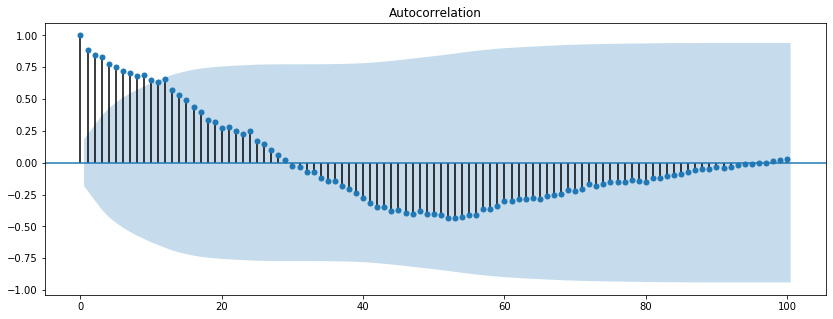

In [18]:
rcParams['figure.figsize'] = 14, 5

plot_acf(monthly_crime, lags=100, alpha=0.05);

From the ACF plot we understand that at a 95% confidence (shown by the shaded area), only the first few lags or up to 9 lags have a significant correlation, i.e, that the series is strongly correlated only for the first couple of lags and decays after that. This could be evidence that the series is random walk
We also see that there is presence of both trend and seasonality in the data.

>"When data have a trend, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size. So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase. When data are seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags." -- [source](https://otexts.com/fpp2/autocorrelation.html)



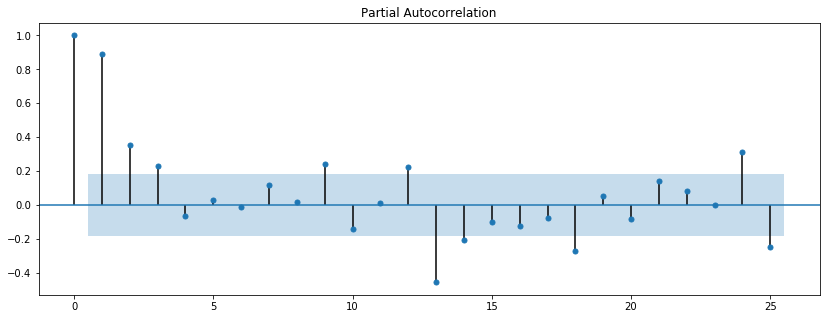

In [21]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(monthly_crime, lags=25, alpha=0.05);

From the PACF plot we see that the time series is significant for the PACF up to 3 lags after which significant lags can be seen only at around lag 12 and lag 13.

In [17]:
# monthly_crime = pd.read_pickle('data/pickled/monthly_crime.pkl')

#### EDA - Trend
Before models can be run it is important to check the data for stationary assumption. This is because in certain models, we don't want our data to be dependent on time.
One way to check on trend is to do a seasonal decomposition on the data, specially for data that fluctuates in time.

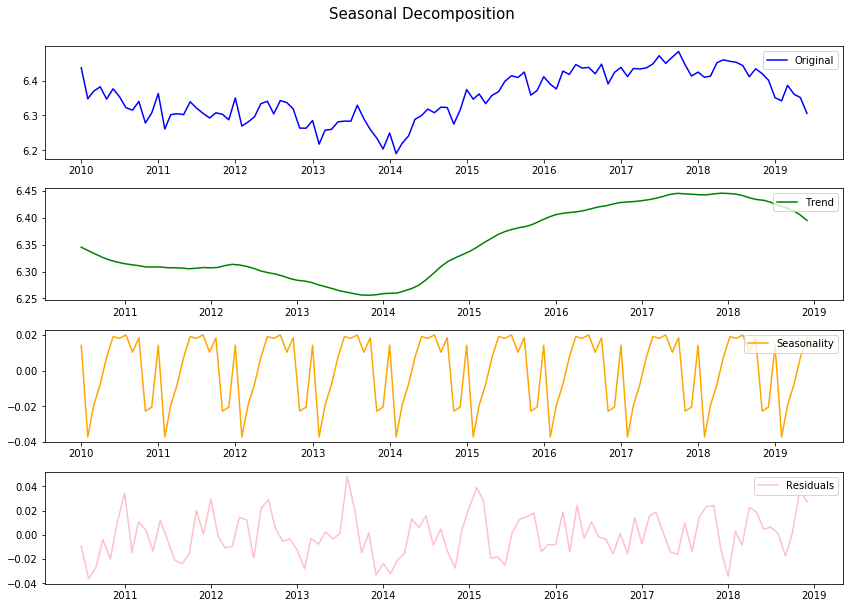

In [19]:
# Instantiating decomposition object
decomposition = seasonal_decompose(np.log(monthly_crime))

# Gather the trend, seasonality, and residuals for the monthly crime data
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.suptitle('Seasonal Decomposition', y = 1.05, size = 15)

#plotting original data in a subplot and showing legend
plt.subplot(411)
plt.plot(np.log(monthly_crime), label='Original', color='blue')
plt.legend(loc=1)

#plotting decomposed trend in a subplot and showing legend
plt.subplot(412)
plt.plot(trend, label='Trend', color='green')
plt.legend(loc=1)

#plotting decomposed seasonality in a subplot and showing legend
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='orange')
plt.legend(loc=1)
plt.subplot(414)

#plotting decomposed residual or noise in a subplot and showing legend
plt.plot(residual, label='Residuals', color='pink')
plt.legend(loc=1)
plt.tight_layout()

The first subplot on the very top shows the plot for the original data with no decomposition. The second subplot shows a clear smooth trend pattern in the data. This is clear evidence of a non-constant mean.

The third subplot shows the decomposed seasonality pattern in the data. The last subplot shows the noise or residual component in the time series data. 

We also looked at the rolling statistics to confirm any instances of non-stationarity.

In [20]:
# calculating rolling mean and rolling standard deviation
roll_mean = monthly_crime.rolling(window=4, center=False).mean()
roll_std = monthly_crime.rolling(window=4, center=False).std()

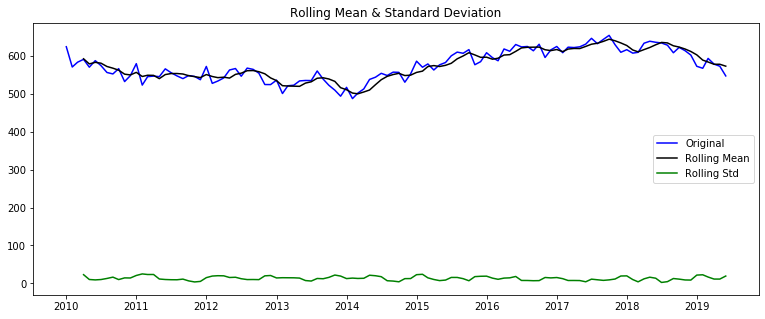

In [21]:
fig = plt.figure(figsize=(13,5))
plt.plot(monthly_crime, color='blue', label='Original')
plt.plot(roll_mean, color='black', label='Rolling Mean')
plt.plot(roll_std, color='green', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

From the figures above we can see that the data violates the stationarity assumption of constant mean, constant variance and constant covariance. 

To tackle this, we will difference the data and check for stationarity. Multiple iterations of differencing were performed and can be found in this [notebook]('draft_model.ipynb')

## Data Modeling

To model time series data, we need to achieve stationarity in the time series. Since, our data in the current state is not stationary, we first attempted differencing at different orders and checking for stationarity.


#### Differencing

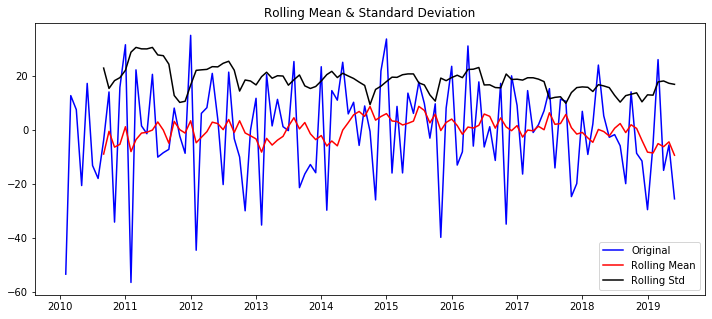

Results of Dickey-Fuller Test: 

Test Statistic                  -1.675236
p-value                          0.443915
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [22]:
#Differencing at 1 period 
crime_diff1 = monthly_crime.diff(periods=1)

#dropping any Nan values
crime_diff1.dropna(inplace=True)

modules.stationarity_check(crime_diff1)

Although the visuals show somewhat stationarity, according to the Dickey Fuller test the one period differenced data fails the stationarity test. Based on the p-value statistic, it is larger than our p-critical value of 0.05 at a 95% confidence. We fail to reject our null hypothesis of Non-Stationarity and state that there is evidence suggesting the 1 period differenced data is not stationary.

Checking at another level of differencing.

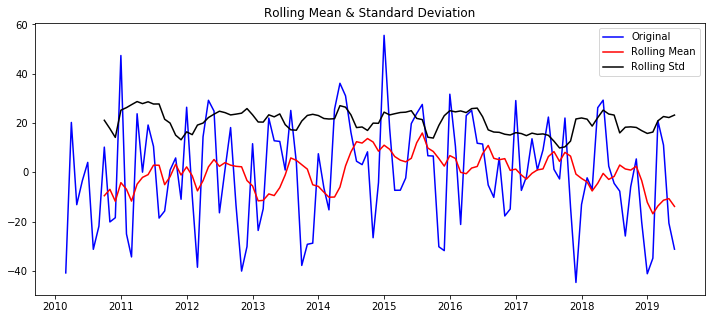

Results of Dickey-Fuller Test: 

Test Statistic                  -1.638325
p-value                          0.463136
#Lags Used                      10.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [23]:
#Differencing at 2nd order 
crime_diff2 = monthly_crime.diff(periods=2)

#dropping any Nan values
crime_diff2.dropna(inplace=True)

modules.stationarity_check(crime_diff2)

At a second period differencing the data is still not stationary. We can also try differencing with the rolling mean

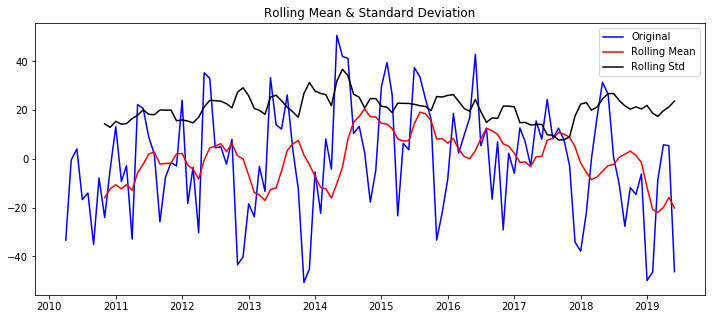

Results of Dickey-Fuller Test: 

Test Statistic                  -1.748441
p-value                          0.406343
#Lags Used                       9.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [24]:
#Differencing at 3rd order 
crime_diff3 = monthly_crime.diff(periods=3)

#dropping any Nan values
crime_diff3.dropna(inplace=True)

modules.stationarity_check(crime_diff3)

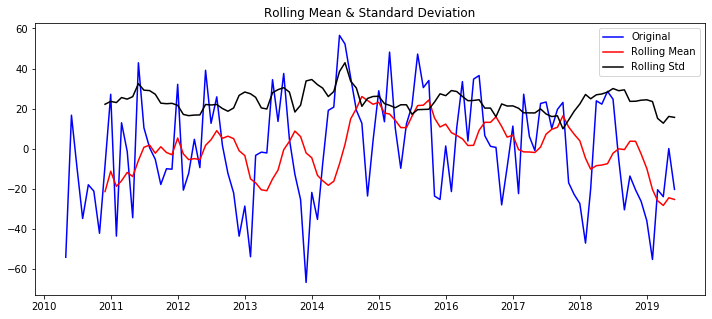

Results of Dickey-Fuller Test: 

Test Statistic                  -1.590990
p-value                          0.488118
#Lags Used                       9.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.890906
Critical Value (10%)            -2.582435
dtype: float64


In [25]:
#Differencing at 4th order 
crime_diff4 = monthly_crime.diff(periods=4)

#dropping any Nan values
crime_diff4.dropna(inplace=True)

modules.stationarity_check(crime_diff4)

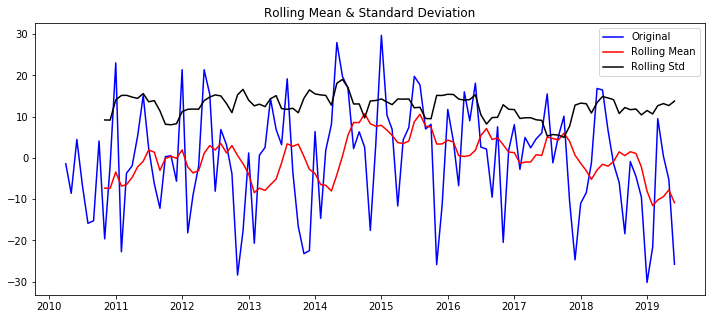

Results of Dickey-Fuller Test: 

Test Statistic                 -1.194470
p-value                         0.675970
#Lags Used                     12.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64


In [26]:
# Subtract the moving average from the original data and previewing
# the roll_mean value comes from the Rolling Statistics calculated above
minus_roll_mean = monthly_crime - roll_mean

#removing Nans
minus_roll_mean.dropna(inplace=True)

modules.stationarity_check(minus_roll_mean)

Even after differencing with the rolling mean the data is still persistantly non- stationary. Although non-stationary, the lowest p-value achieved on the Dickey Fuller test was of 0.40, on the 3rd order differencing. We used the 3rd order differenced time series to model on.

We need to at least **make sure that the residuals or noise in the data is stationary**, to avoid any spurious regressions.
>" If there are no properties of stationarity among the residuals, then basically our results tend to produce
fake relationships in our model.'' --[source](https://blog.ms-researchhub.com/2019/07/12/discussing-the-importance-of-stationary-residuals-in-time-series-8/)

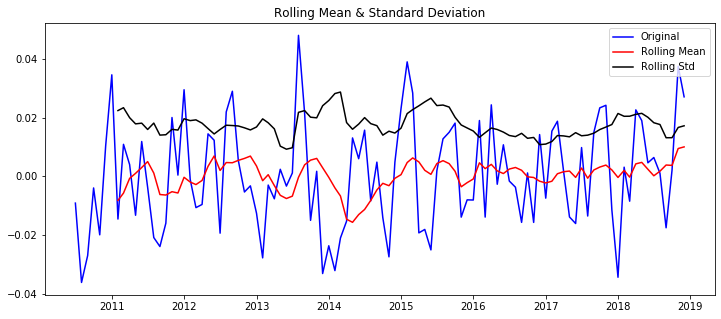

Results of Dickey-Fuller Test: 

Test Statistic                -6.995909e+00
p-value                        7.534967e-10
#Lags Used                     3.000000e+00
Number of Observations Used    9.800000e+01
Critical Value (1%)           -3.498910e+00
Critical Value (5%)           -2.891516e+00
Critical Value (10%)          -2.582760e+00
dtype: float64


In [27]:
# residual value comes from the code block on Seasonal Decomposition
crime_log_decompose = residual

# Drop missing values from residuals 
crime_log_decompose.dropna(inplace=True)

modules.stationarity_check(crime_log_decompose)

The expanded form for the dickey fuller test p- value is 0.0000000007534967. At a 95% confidence, this is clearly less than the p critical value of 0.05. Here we reject the null of non-stationarity and state that there is statistical evidence that the residuals are stationary. 

### Baseline 
**AR model on original dataset**

Splitting original data to train and test

In [28]:
Xo = monthly_crime.index
yo = monthly_crime['crime_count']

train_seto = monthly_crime.loc['2010-01-01':'2017-12-31']
test_seto = monthly_crime.loc['2018-01-01' : ]

X_traino, X_testo = train_seto.index , test_seto.index
y_traino, y_testo = train_seto['crime_count'] , test_seto['crime_count']

In [29]:
#Dictionary to collect model evaluations
mod_eval={}

# Instantiate an AR(1) model to the simulated data
mod_arma = ARMA(y_traino, order=(1,0))

# Fitting model
res_arma = mod_arma.fit()

#adding aic eval to mod eval dict
mod_eval['AR-1_aic']= res_arma.aic

# running model statistics
res_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            crime_count   No. Observations:                   96
Model:                     ARMA(1, 0)   Log Likelihood                -418.127
Method:                       css-mle   S.D. of innovations             18.702
Date:                Mon, 07 Dec 2020   AIC                            842.254
Time:                        18:12:32   BIC                            849.947
Sample:                    01-01-2010   HQIC                           845.363
                         - 12-01-2017                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               576.7839     15.421     37.402      0.000     546.559     607.009
ar.L1.crime_count     0.8834      0.047     18.709      0.000       0.791       0.976
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1320           +0.0000j            1.1320            0.0000
-----------------------------------------------------------------------------
"""

In [30]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = res_arma.predict(start='2018-01-01', end='2019-06-30',dynamic=False)

# Compute the mean square error
rmse = np.sqrt(((pred - y_testo)**2).mean())

#adding rmse eval to mod eval dict
mod_eval['AR-1_rmse']= rmse

print('The Root Mean Squared Error of our predictions is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our predictions is 27.53


**MA model on original dataset**

In [31]:
# Instantiate an MA(1) model to the simulated data
mod2_arma = ARMA(y_traino, order=(0,1))

# Fitting model
res_arma2 = mod2_arma.fit()

#adding aic eval to mod eval dict
mod_eval['MA-1_aic']= res_arma2.aic

# running model statistics
res_arma2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            crime_count   No. Observations:                   96
Model:                     ARMA(0, 1)   Log Likelihood                -454.089
Method:                       css-mle   S.D. of innovations             27.307
Date:                Mon, 07 Dec 2020   AIC                            914.178
Time:                        18:12:34   BIC                            921.871
Sample:                    01-01-2010   HQIC                           917.288
                         - 12-01-2017                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               570.8737      4.807    118.760      0.000     561.452     580.295
ma.L1.crime_count     0.7323      0.058     12.545      0.000       0.618       0.847
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.3655           +0.0000j            1.3655            0.5000
-----------------------------------------------------------------------------
"""

In [32]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = res_arma2.predict(start='2018-01-01', end='2019-06-30',dynamic=False)

# Compute the mean square error
rmse = np.sqrt(((pred - y_testo)**2).mean())

#adding rmse eval to mod eval dict
mod_eval['MA-1_rmse']= rmse

print('The Root Mean Squared Error of our predictions is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our predictions is 42.64


**AR model on differenced dataset**

Using the 3rd order differenced time series. First we split the 3rd order differenced time series.

In [33]:
X = crime_diff3.index
y = crime_diff3['crime_count']

train_set = crime_diff3.loc['2010-01-01':'2017-12-31']
test_set = crime_diff3.loc['2018-01-01' : ]

X_train, X_test = train_set.index , test_set.index
y_train, y_test = train_set['crime_count'] , test_set['crime_count']

In [34]:
# Instantiate an AR(1) model to the simulated data
mod3_arma = ARMA(train_set, order=(1,0))

# Fitting model
res_arma3 = mod3_arma.fit()

#adding aic eval to mod eval dict
mod_eval['AR-1-diff_aic']= res_arma3.aic

# running model statistics
res_arma3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            crime_count   No. Observations:                   93
Model:                     ARMA(1, 0)   Log Likelihood                -411.586
Method:                       css-mle   S.D. of innovations             20.202
Date:                Mon, 07 Dec 2020   AIC                            829.171
Time:                        18:12:37   BIC                            836.769
Sample:                    04-01-2010   HQIC                           832.239
                         - 12-01-2017                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7434      3.469      0.214      0.830      -6.056       7.543
ar.L1.crime_count     0.3995      0.097      4.103      0.000       0.209       0.590
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5033           +0.0000j            2.5033            0.0000
-----------------------------------------------------------------------------
"""

In [35]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = res_arma3.predict(start='2018-01-01', end='2019-06-30',dynamic=False)

# Compute the mean square error
rmse = np.sqrt(((pred - y_test)**2).mean())

#adding rmse eval to mod eval dict
mod_eval['AR-1-diff_rmse']= rmse

print('The Root Mean Squared Error of our predictions is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our predictions is 25.1


In [36]:
mod_eval

{'AR-1_aic': 842.2535557241645,
 'AR-1_rmse': 27.532841861531214,
 'MA-1_aic': 914.1779426862158,
 'MA-1_rmse': 42.63506502440911,
 'AR-1-diff_aic': 829.1713703808396,
 'AR-1-diff_rmse': 25.103903047528473}

In [37]:
# Instantiate an MA(1) model to the simulated data
mod4_arma = ARMA(train_set, order=(0,1))

# Fitting model
res_arma4 = mod4_arma.fit()

#adding aic eval to mod eval dict
mod_eval['MA-1-diff_aic']= res_arma4.aic

# running model statistics
res_arma4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            crime_count   No. Observations:                   93
Model:                     ARMA(0, 1)   Log Likelihood                -413.871
Method:                       css-mle   S.D. of innovations             20.715
Date:                Mon, 07 Dec 2020   AIC                            833.742
Time:                        18:12:39   BIC                            841.340
Sample:                    04-01-2010   HQIC                           836.810
                         - 12-01-2017                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.0325      2.749      0.376      0.707      -4.356       6.421
ma.L1.crime_count     0.2828      0.079      3.572      0.000       0.128       0.438
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -3.5367           +0.0000j            3.5367            0.5000
-----------------------------------------------------------------------------
"""

In [38]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = res_arma4.predict(start='2018-01-01', end='2019-06-30',dynamic=False)

# Compute the mean square error
rmse = np.sqrt(((pred - y_test)**2).mean())

#adding rmse eval to mod eval dict
mod_eval['MA-1-diff_rmse']= rmse

print('The Root Mean Squared Error of our predictions is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our predictions is 25.67


In [39]:
mod_eval

{'AR-1_aic': 842.2535557241645,
 'AR-1_rmse': 27.532841861531214,
 'MA-1_aic': 914.1779426862158,
 'MA-1_rmse': 42.63506502440911,
 'AR-1-diff_aic': 829.1713703808396,
 'AR-1-diff_rmse': 25.103903047528473,
 'MA-1-diff_aic': 833.7424340308055,
 'MA-1-diff_rmse': 25.669181972233545}

So far we can see that the best model based on the AIC and the RMSE, is the AR model with a 'p' term of 1 on the 3rd order differenced time series.

#### ARMA model

In [40]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(1, 6)

# Generate all different combinations of p, q and q triplets
pq = list(itertools.product(p, q))


In [41]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pq:
    try:
        mod = ARMA(train_set, order=comb)
        output = mod.fit()
        ans.append([comb, output.aic])
        print('ARMA {} : AIC Calculated ={}'.format(comb,output.aic))
    except:
        continue

ARMA (1, 1) : AIC Calculated =831.0041896275129
ARMA (1, 2) : AIC Calculated =798.3644321700156
ARMA (1, 3) : AIC Calculated =799.4727010366637
ARMA (1, 4) : AIC Calculated =801.4655962510506
ARMA (1, 5) : AIC Calculated =802.9493093452086
ARMA (2, 1) : AIC Calculated =830.4368004733628
ARMA (2, 2) : AIC Calculated =799.5679449718473
ARMA (2, 3) : AIC Calculated =801.5394679632434
ARMA (2, 4) : AIC Calculated =802.9648565704526
ARMA (2, 5) : AIC Calculated =804.5470650785555
ARMA (3, 1) : AIC Calculated =826.2635775611939
ARMA (3, 2) : AIC Calculated =801.5457577141049
ARMA (3, 3) : AIC Calculated =803.0352669556289
ARMA (3, 4) : AIC Calculated =803.6407228096275
ARMA (4, 1) : AIC Calculated =828.2967148381376
ARMA (4, 2) : AIC Calculated =803.1714099495534
ARMA (4, 3) : AIC Calculated =804.9762534177653
ARMA (4, 4) : AIC Calculated =806.3225151759164
ARMA (4, 5) : AIC Calculated =800.5478181626072
ARMA (5, 1) : AIC Calculated =826.5716733698694
ARMA (5, 2) : AIC Calculated =802.796824

In [42]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq     (1, 2)
aic    798.364
Name: 1, dtype: object

In [43]:
# Instantiate an AR(1) model to the simulated data
mod5_arma = ARMA(y_train, order=(3,5))

# Fitting model
res_arma5 = mod5_arma.fit()

#adding aic eval to mod eval dict
mod_eval['ARMA-3,5-diff_aic']= res_arma5.aic

# running model statistics
res_arma5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            crime_count   No. Observations:                   93
Model:                     ARMA(3, 5)   Log Likelihood                -387.376
Method:                       css-mle   S.D. of innovations             14.543
Date:                Mon, 07 Dec 2020   AIC                            794.751
Time:                        18:13:12   BIC                            820.077
Sample:                    04-01-2010   HQIC                           804.977
                         - 12-01-2017                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0380      4.478     -0.008      0.993      -8.815       8.739
ar.L1.crime_count    -0.7497      0.069    -10.812      0.000      -0.886      -0.614
ar.L2.crime_count     0.7554      0.121      6.260      0.000       0.519       0.992
ar.L3.crime_count     0.9942      0.069     14.427      0.000       0.859       1.129
ma.L1.crime_count     1.7606      0.097     18.093      0.000       1.570       1.951
ma.L2.crime_count     0.9778        nan        nan        nan         nan         nan
ma.L3.crime_count    -0.9876        nan        nan        nan         nan         nan
ma.L4.crime_count    -1.7608        nan        nan        nan         nan         nan
ma.L5.crime_count    -0.9901        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0000           -0.0000j            1.0000           -0.0000
AR.2           -0.8799           -0.4812j            1.0029           -0.4204
AR.3           -0.8799           +0.4812j            1.0029            0.4204
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.4921           -0.8705j            1.0000           -0.3319
MA.3           -0.4921           +0.8705j            1.0000            0.3319
MA.4           -0.8971           -0.4530j            1.0050           -0.4256
MA.5           -0.8971           +0.4530j            1.0050            0.4256
-----------------------------------------------------------------------------
"""

In [44]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = res_arma5.predict(start='2018-01-01', end='2019-06-30',dynamic=False)

# Compute the mean square error
rmse = np.sqrt(((pred - y_test)**2).mean())

#adding rmse eval to mod eval dict
mod_eval['ARMA-3,5-diff_rmse']= rmse

print('The Root Mean Squared Error of our predictions is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our predictions is 23.63


In [45]:
mod_eval

{'AR-1_aic': 842.2535557241645,
 'AR-1_rmse': 27.532841861531214,
 'MA-1_aic': 914.1779426862158,
 'MA-1_rmse': 42.63506502440911,
 'AR-1-diff_aic': 829.1713703808396,
 'AR-1-diff_rmse': 25.103903047528473,
 'MA-1-diff_aic': 833.7424340308055,
 'MA-1-diff_rmse': 25.669181972233545,
 'ARMA-3,5-diff_aic': 794.7511205444516,
 'ARMA-3,5-diff_rmse': 23.628377498239292}

Based on our model iterations, we see from the model evaluation output above that the ARMA model with a p term of 3 and q term of 5 did the best with the lowest AIC and RMSE values.

Since, there is seasonality present in our data we will also run a SARIMA model that takes into account the seasonality aspect of the time series as well as the non stationarity aspect.

#### SARIMAX model

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [ ]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [46]:
# Plug the optimal parameter values into a new SARIMAX model
SARIMA_mod6 = sm.tsa.statespace.SARIMAX(y_traino, order=(0, 2, 2), 
                                        seasonal_order=(2, 2, 2, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = SARIMA_mod6.fit()

#adding aic eval to mod eval dict
mod_eval['SARIMA_aic']= output.aic

output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        crime_count   No. Observations:                   96
Model:             SARIMAX(0, 2, 2)x(2, 2, 2, 12)   Log Likelihood                -185.424
Date:                            Mon, 07 Dec 2020   AIC                            384.848
Time:                                    18:13:44   BIC                            397.176
Sample:                                01-01-2010   HQIC                           389.394
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5500    355.817     -0.004      0.997    -698.938     695.838
ma.L2          0.5500    195.644      0.003      0.998    -382.905     384.005
ar.S.L12      -0.2766      0.172     -1.613      0.107      -0.613       0.060
ar.S.L24      -0.1770      0.181     -0.979      0.328      -0.531       0.177
ma.S.L12      -1.5268   3902.947     -0.000      1.000   -7651.162    7648.109
ma.S.L24       1.0000   5113.100      0.000      1.000      -1e+04       1e+04
sigma2       147.3865    7.7e+05      0.000      1.000   -1.51e+06    1.51e+06
===================================================================================
Ljung-Box (Q):                       37.29   Jarque-Bera (JB):                 0.94
Prob(Q):                              0.59   Prob(JB):                         0.62
Heteroskedasticity (H):               0.66   Skew:                            -0.10
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

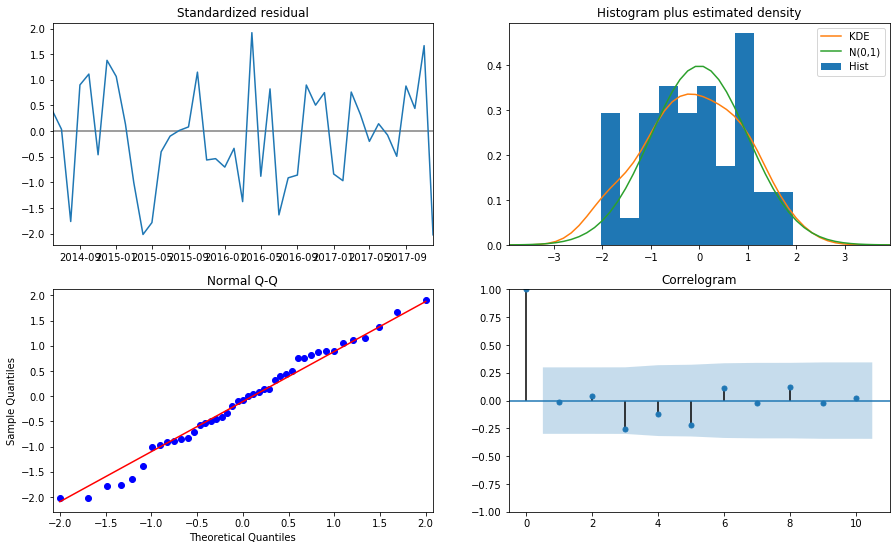

In [49]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 9))

plt.savefig('./visualizations/SARIMA Plot Diagnostics.png')
plt.show()

### from canvas lesson

The purpose here is to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model.

Checking for these assumptions from diagnostics plots:

* In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). There is a good indication that the residuals are close to normally distributed.

* The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) weakly follows the linear trend of the samples taken from a standard normal distribution with N(0, 1).There is fair indication that the residuals are normally distributed.

* The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.

In [50]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start='2018-01-01', end='2019-06-30',dynamic=False)
# start='2018-01-01', end='2019-06-30'
pred_conf = pred.conf_int()
pred_conf.head()

,lower crime_count,upper crime_count
2018-01-01,615.333759,672.658340
2018-02-01,606.393968,670.729386
2018-03-01,594.327972,665.632909
2018-04-01,593.707152,671.959801
2018-05-01,581.875534,667.059061


In [51]:
# Get the real and predicted values
Crime_forecasted = pred.predicted_mean
Crime_truth = y_testo

# Compute the mean square error
rmse = np.sqrt(((Crime_forecasted - Crime_truth)**2).mean())

#adding rmse eval to mod eval dict
mod_eval['SARIMA_rmse']= rmse

print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 24.68


In [52]:
mod_eval

{'AR-1_aic': 842.2535557241645,
 'AR-1_rmse': 27.532841861531214,
 'MA-1_aic': 914.1779426862158,
 'MA-1_rmse': 42.63506502440911,
 'AR-1-diff_aic': 829.1713703808396,
 'AR-1-diff_rmse': 25.103903047528473,
 'MA-1-diff_aic': 833.7424340308055,
 'MA-1-diff_rmse': 25.669181972233545,
 'ARMA-3,5-diff_aic': 794.7511205444516,
 'ARMA-3,5-diff_rmse': 23.628377498239292,
 'SARIMA_aic': 384.84753066840403,
 'SARIMA_rmse': 24.6799747309774}

We find that there is relatively small difference in the model RMSE for ARMA-3,5 vs SARIMA but the AIC for the SARIMA is significantly lower, indicating a better fit model. Therfore, our final best model is the SARIMA.

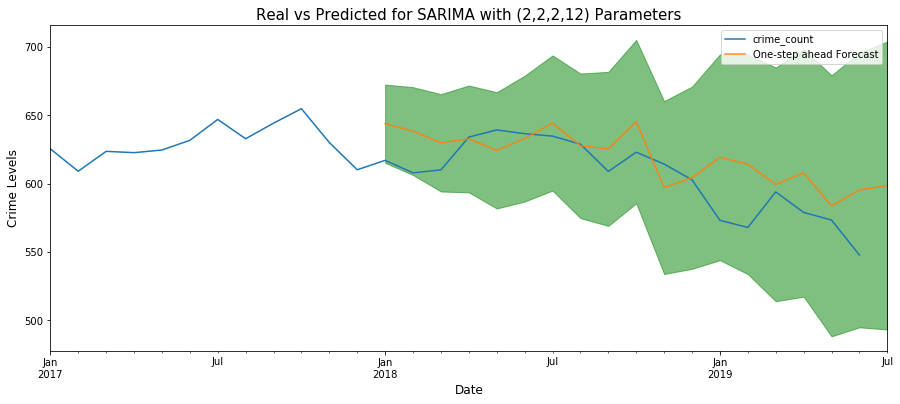

In [53]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = monthly_crime['2017-01-01':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels and title
ax.set_xlabel('Date', size=12)
ax.set_ylabel('Crime Levels',size=12)
ax.set_title('Real vs Predicted for SARIMA with (2,2,2,12) Parameters', size=15)

plt.legend()

plt.show()

In [54]:
# Get forecast 24 steps ahead in future
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

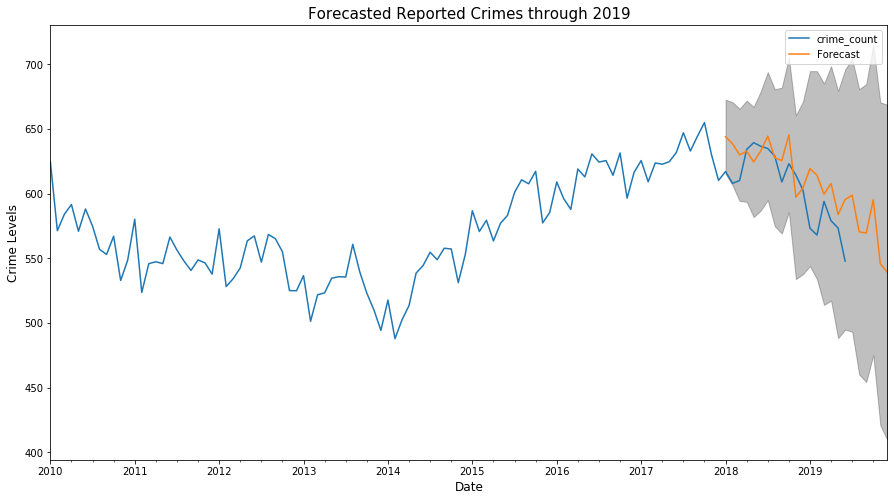

<Figure size 1080x432 with 0 Axes>

In [55]:
# Plot future predictions with confidence intervals
ax = monthly_crime.plot(label='observed', figsize=(15, 8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)

#setting axes labels and title
ax.set_xlabel('Date', size = 12)
ax.set_ylabel('Crime Levels', size = 12)
ax.set_title('Forecasted Reported Crimes through 2019', size = 15)

plt.legend()
plt.show()
plt.savefig('./visualizations/final_model_forecasts.png')

## Final Model Analysis

## Recommendations